# Тестирование  рекуррентной нейронной сети для генерации текстов

В этом ноутбуке мы рассмотрим рекуррентную нейросеть небольшого размера, обученную на первом томе романа "Война и мир" Л. Н. Толстого. Такая нейронная сеть умеет генерировать продолжения фраз на русском языке. 

В задании Вы:
* сгенерируете свои предсказания с помощью нейронной сети
* визуализируете векторные представления слов с помощью метода tSNE
* поищите близкие слова с помощью векторных представлений слов
* попробуете вычислять метрику BLEU, оценивающую похожесть двух текстовых последовательностей.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from collections import Counter
import os
from argparse import Namespace

### Гиперпараметры

In [2]:
flags = Namespace(
    seq_size=32, # максимальная длина текста (в словах)
    embedding_size=64, # число элементов в векторных представлениях слов
    lstm_size=64, # число нейронов в рекуррентном слое
)

### Сборка нейросети

In [3]:
class RNNModule(nn.Module):
    def __init__(self, n_vocab, seq_size, embedding_size, lstm_size):
        super(RNNModule, self).__init__()
        self.seq_size = seq_size
        self.lstm_size = lstm_size
        # слой векторных представлений (эмбеддингов)
        self.embedding = nn.Embedding(n_vocab, embedding_size)
        # рекуррентный слой
        self.lstm = nn.LSTM(embedding_size,
                            lstm_size,
                            batch_first=True)
        # полносвязный слой для предсказания следующего слова
        self.dense = nn.Linear(lstm_size, n_vocab)

    def forward(self, x, prev_state):
        # x: (16, 32): 16 объектов, 32 слова в каждом
        embed = self.embedding(x) # (16, 32, 64): 64 - размер векторного представления
        output, state = self.lstm(embed, prev_state) # (16, 32, 64)
        logits = self.dense(output) # (16, 32, 22782), 22782 - число слов в словаре

        return logits, state

    def zero_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.lstm_size),
                torch.zeros(1, batch_size, self.lstm_size))

Cоздаем конкретный экземпляр нейросети (пока с бессмысленными случайно инициализированными весами):

In [4]:
net = RNNModule(22782, flags.seq_size,
                flags.embedding_size, flags.lstm_size)

### Загрузка данных и обученной модели

In [5]:
save = torch.load("/home/sber50/notebooks/net.dict")
net.load_state_dict(save["net"])
n_vocab = save["n_vocab"]
vocab_to_int = save["vocab_to_int"]
int_to_vocab = save["int_to_vocab"]

In [6]:
n_vocab

22782

Посмотрим на 20 самых частых слов:

In [7]:
for idx in range(20):
    print(int_to_vocab[idx])

,
.
и
—
в
не
на
что
он
с
как
!
к
его
?
сказал
я
было
это
;


Найдем номер слова "Наташа":

In [8]:
vocab_to_int["Наташа"]

252

### Функция для выполнения предсказания

Функция выполняет следующие шаги:
* предобработка заданной последовательности (разделение на слова по пробелам)
* обработка последовательности с помощью нейросети
* предсказание следующего слова заданное количество раз

In [9]:
def predict(net, n_vocab, vocab_to_int, int_to_vocab,
             words="Зачем мне", top_k=5, length=100):
    words = words.split() # разделение текста на слова по пробелам
    
    net.eval()

    # обработка данных слов
    state_h, state_c = net.zero_state(1)
    for w in words:
        ix = torch.tensor([[vocab_to_int[w]]])
        output, (state_h, state_c) = net(ix, (state_h, state_c))

    # предсказание первого следующего слова (случайный выбор из top_k слов)
    _, top_ix = torch.topk(output[0], k=top_k)
    choices = top_ix.tolist()
    choice = np.random.choice(choices[0])

    words.append(int_to_vocab[choice])

    # повторение процедуры генерации length раз
    for _ in range(length):
        ix = torch.tensor([[choice]])
        output, (state_h, state_c) = net(ix, (state_h, state_c))

        _, top_ix = torch.topk(output[0], k=top_k)
        choices = top_ix.tolist()
        choice = np.random.choice(choices[0])
        words.append(int_to_vocab[choice])

    return ' '.join(words)

### Выполняем предсказания

Функция predict принимает на вход следующие аргументы:
* net: обученная нейросеть - см. раздел Загрузка данных и обученной модели
* n_vocab: число слов в словаре - см. раздел Загрузка данных и обученной модели
* vocab_to_int: словарь, возвращающий номер слова - см. раздел Загрузка данных и обученной модели
* int_to_vocab: словарь, возвращающий слова по их номеру - см. раздел Загрузка данных и обученной модели
* (!) my_input: строка, которую нужно продолжить
* (!) top_k: из скольки слов с наибольшими предсказанными вероятностями выбирать следующее слово 
* (!) length: сколько слов генерировать

Пример генерации продолжения:

In [10]:
my_input = "Завтра поедем выбирать новую шубу"
predict(net, n_vocab,
                    vocab_to_int, int_to_vocab, my_input, top_k=1,\
       length=10)

'Завтра поедем выбирать новую шубу , — сказала старая графиня , проходя через залу и улыбнулась'

__Задание.__ Сгенерируйте продолжения для нескольких фраз, которые Вы придумаете. 

Если в Вашем предложении будут слова, которых не было в обучающих данных (в первом томе), выдастся ошибка. К сожалению, в этом случае придеся изменить предложение.

__Задание.__ Попробуйте варьировать параметры:
* Попробуйте генерировать длинные продолжения: length=100. Верно ли, что в начале продолжения текст более осмысленный (хотя бы насколько-нибудь), чем в конце?
* Попробуйте менять параметр top_k (из скольки наиболее вероятных следующих слов делать случайный выбор). Попробуйте k=1, k=3, k=20. Как влияет k на качество генерируемых продолжений?

### Визуализация векторных представлений

При обучении нейросети для каждого слова мы выучили векторное представление -- набор чисел, характеризующих его смысл. Этот набор чисел понятен только нейросети, мы его интерпретировать не можем. Но мы можем визуализировать векторные представления и попытаться найти в них какую-то структуру.

Для начала извлечем таблицу векторных представлений из модели:

In [11]:
embs = net.embedding.weight.detach().cpu().numpy()

In [12]:
embs.shape # число слов, размер векторного представления

(22782, 64)

Пример векторного представления:

In [13]:
embs[0]

array([ 0.48384216,  0.3189694 ,  0.1700915 , -0.11458367, -0.10301524,
       -1.1690301 ,  0.38778594,  0.5920238 ,  0.130598  ,  0.23635785,
       -0.9997578 , -0.71189773, -0.3779874 , -0.711161  , -1.3358569 ,
       -0.11525764,  0.241066  ,  0.1798417 ,  0.3323485 ,  0.57619524,
       -0.57826173, -0.19859928,  0.24085268,  1.3594143 ,  0.4270676 ,
        0.18791378,  0.3758226 ,  1.7573667 , -0.37461475,  0.90953875,
        0.88424164, -0.16349766, -0.27682295, -0.7802633 , -0.6342541 ,
        0.94474924,  0.6307871 , -0.18897489, -0.43013066, -2.1848588 ,
       -0.98522854,  0.62291276, -2.720233  , -0.20365648, -0.3813623 ,
       -0.7290697 ,  0.27388793,  0.6884718 , -0.03741877, -0.4365542 ,
        0.8986192 , -0.58165354,  0.68537104, -0.26316145, -0.64776695,
        0.49379987, -0.06059999, -0.04448707,  0.72009695,  0.8129411 ,
        1.5799985 , -0.49638534, -1.7179551 , -0.10294399], dtype=float32)

Будем визуализировать векторные представления с помощью метода tSNE: он находит для каждого слова точку на плоскости так, чтобы сохранить информацию о расстояниях между представлениями. 

Код для применения метода tSNE выглядит так:
   
tsne = TSNE()

res = tsne.fit_transform(таблица векторных представлений)

Вам нужно подставить в код выше первые 300 строк нашей таблицы векторных представлений. Чтобы выделить первые 300 строк, припишите к переменной [:300].
 
__Задание.__ Примените метод tSNE к таблице векторных представлений слов (первые 300 слов).

In [14]:
from sklearn.manifold import MDS

In [15]:
tsne = MDS()
res = tsne.fit_transform(embs[:300])

В результате для каждого из 300 слов мы знаем 2 координаты на плоскости, где расположить это слово:

In [16]:
res.shape

(300, 2)

Выполним визуализацию:

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline

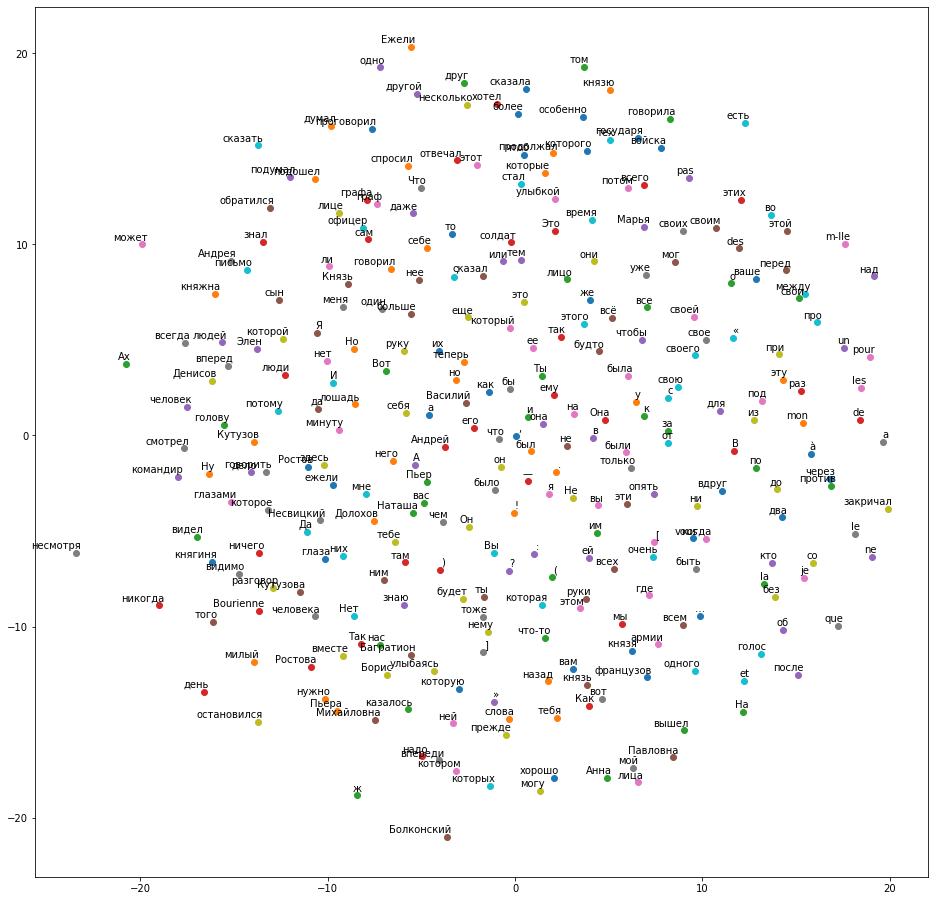

In [20]:
x = res[:, 0]
y = res[:, 1]
labels = [int_to_vocab[i] for i in range(len(x))]
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    if x[i] > -200 and x[i] < 200 and y[i] > -200 and y[i] < 200:
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

__Задание.__ Рассмотрите визуализацию: найдите группы похожих слов.

### Поиск похожих слов

Попробуем использовать наши векторные представления для поиска похожих слов. Код, данный ниже, находит для слова my_word топ-3 близких к нему слова.  Будем искать только среди первой тысячи слов, потому что для них выучились наиболее стабильные векторные представления.

Вам нужно дописать начало этой функции: 
* idx: извлечь номер слова из словаря (используйте переменную vocab_to_int, созданную в разделе Загрузка данных и обученной модели)
* my_emb: извлечь векторное представление по номеру (используйте переменную embs, созданную в разделе Визуализация векторных представлений)

Для извлечения элемента используйте квадратные скобки.

__Задание.__ Допишите функию find_words.

In [22]:
from sklearn.metrics import pairwise_distances

In [23]:
def find_words(my_word):
    idx = vocab_to_int[my_word] # номер слова
    my_emb = embs[idx] # векторное представление слова
    # вычисление расстояний до других слов
    dists = pairwise_distances(embs[:1000], my_emb[None, :], \
                               metric="cosine")
    # поиск трех наиболее похожих
    idxs2 = np.argsort(dists.ravel())[:3]
    # печать результата
    for idx2 in idxs2:
        print(int_to_vocab[idx2], dists[idx2])

Протестируем функцию: найдем слова, близкие к слову "она":

In [24]:
find_words("она")

она [0.]
Она [0.51782924]
Княжна [0.6152046]


__Задание.__ Найдите слова, близкие к словам "он", "офицер", "Ростова".

### Вычисление метрики BLEU

Метрика BLEU измеряет, насколько похожи текстовые последовательности. Обычно ее используют в задаче перевода, когда смысл предложения, которое нужно предсказать, определен (совпадает со смыслом предложения на другом языке), но перевод можно сформулировать по-разному. Исследования показывают, что метрика BLEU неплохо коррелирует с экспертной оценкой переводов.

Напишем простую функцию для вычисления метрики:

In [25]:
import nltk
def get_bleu(true, predicted):
    reference = true.split()
    hypothesis = predicted.split()
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, \
                                                        weights = (0.5, 0.5))
    return BLEUscore

Пример:

In [26]:
true = "Девушка держит чашку кофе"
predicted = "Девушка держит в руке чашку кофе"
get_bleu(true, predicted)

0.5163977794943222

__Задание.__ Вычислите BLEU, когда предсказанное предложение в точности совпадает с правильным.

__Задание.__ Вычислите BLEU для своей модификации предложения про кофе.

Вы можете также попробовать вычислять BLEU для своих пар предложений. 

Кроме того, можно попробовать найти строчку из [второго тома "Войны и мира"](http://az.lib.ru/t/tolstoj_lew_nikolaewich/text_0050.shtml), сделать для него предсказание с помощью нейронной сети и вычислить BLEU относительно настоящего продолжения из романа. 

Правда, скорее всего, Вы получите значение BLEU около нуля, потому что, вообще говоря, нейросеть не знает, о чем именно написано дальше в предложении, поэтому сгенерировать точное по смысле продолжение она гипотетически не может.

Если Вы все сделали, предлагаем также попробовать демонстрации, доступные в онлайн-сервисах:
* [Порфирьевич](https://porfirevich.ru/): решает ту же задачу, которую решали мы, однако нейросеть в сервисе обучена на большем объеме данных и имеет больше параметров, так что генерирует более осмысленные продолжения.
* [Генерация подписей к изображениям](https://milhidaka.github.io/chainer-image-caption/): загрузите изображение (Choode file) и нажмите кнопку Generate caption. Для перевода результатов можно воспользоваться [Google-переводчиком](https://translate.google.com/).